In [49]:
import pandas as pd
import numpy as np
import pylab as pl
import PIL
from PIL import Image
import os
import base64
from StringIO import StringIO
from pprint import pprint

In [356]:
from sklearn.decomposition import RandomizedPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [357]:
%matplotlib inline

In [358]:
import csv

In [215]:
from bs4 import BeautifulSoup
import requests
import re
import urllib2
import os


def get_soup(url):
    return BeautifulSoup(requests.get(url).text)

image_type = "stopsign"
query = "stop sign"
url = "http://www.bing.com/images/search?q=" + query + \
    "&qft=+filterui:color2-bw+filterui:imagesize-large&FORM=R5IR3"

soup = get_soup(url)
images = [a['src'] for a in soup.find_all("img", {"src": re.compile("mm.bing.net")})]

for img in images:
    raw_img = urllib2.urlopen(img).read()
    cntr = len([i for i in os.listdir("img") if image_type in i]) + 1
    f = open("./img/" + image_type + "_"+ str(cntr), 'wb')
    f.write(raw_img)
    f.close()

<h2>Importing Image Data</h2>

<h5>Create Processing Functions</h5>

In [359]:
#setup a standard image size; this will distort some images but will get everything into the same shape
STANDARD_SIZE = (100, 56)
def img_to_matrix(filename, verbose=False):
    """
    takes a filename and turns it into a numpy array of RGB pixels
    """
    img = PIL.Image.open(filename)
    if verbose==True:
        print "changing size from %s to %s" % (str(img.size), str(STANDARD_SIZE))
    img = img.resize(STANDARD_SIZE)
    img = list(img.getdata())
    img = map(list, img)
    img = np.array(img)
    return img

def flatten_image(img):
    """
    takes in an (m, n) numpy array and flattens it 
    into an array of shape (1, m * n)
    """
#     print img.shape[0]
#     print img.shape[1]
    s = img.shape[0] * img.shape[1]
    img_wide = img.reshape(1, s)
    return img_wide[0]

<h5>Define the location of your data and import it</h5>

In [360]:
# TODO PATH TO YOUR DATA
img_dir = "./img/"
images = [img_dir+ f for f in os.listdir(img_dir)]
labels = [f.split('/')[-1].split('.')[0].split('_')[0] for f in images]

imagedict = {}

data = []
for image in images:
    img = img_to_matrix(image)
    img = flatten_image(img)
    imagedict.setdefault(image, []).append(img)
    data.append(img)

data = np.array(data)
data

array([[221, 221, 221, ..., 221, 221, 221],
       [220, 220, 220, ..., 224, 224, 224],
       [221, 221, 221, ..., 221, 221, 221],
       ..., 
       [221, 221, 221, ..., 221, 221, 221],
       [221, 221, 221, ..., 221, 221, 221],
       [221, 221, 221, ..., 221, 221, 221]])

In [361]:
writer = csv.writer(open('imagedict.csv', 'wb'))
for key, value in imagedict.items():
    loc0 = key.split('/')[-1].split('.')[0].split('_')[0]
    pixels = value[0]
    writer.writerow(pixels)

<h2>Creating Features</h2>

<h5>Define a training and test set</h5>

In [362]:
is_train = np.random.uniform(0, 1, len(data)) <= 0.7
y = np.where(np.array(labels)=="speedlimit", 1, 0)

train_x, train_y = data[is_train], y[is_train]
test_x, test_y = data[is_train==False], y[is_train==False]

In [363]:
train_x

array([[221, 221, 221, ..., 221, 221, 221],
       [220, 220, 220, ..., 224, 224, 224],
       [221, 221, 221, ..., 221, 221, 221],
       ..., 
       [221, 221, 221, ..., 221, 221, 221],
       [221, 221, 221, ..., 221, 221, 221],
       [221, 221, 221, ..., 221, 221, 221]])

In [364]:
train_y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [365]:
test_x

array([[221, 221, 221, ..., 221, 221, 221],
       [221, 221, 221, ..., 221, 221, 221],
       [221, 221, 221, ..., 221, 221, 221],
       ..., 
       [221, 221, 221, ..., 221, 221, 221],
       [221, 221, 221, ..., 221, 221, 221],
       [221, 221, 221, ..., 221, 221, 221]])

In [366]:
test_y

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

<h5>RandomizedPCA to create features</h5>
<p>Before we actually create our feature vectors, we're going to show a demo of <code>RandomizedPCA</code> in 2 dimensions. This makes it easy to plot high dimensional data</p>

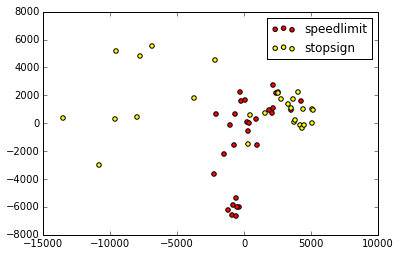

In [367]:
pca = RandomizedPCA(n_components=3)
X = pca.fit_transform(data)
df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1], "label":np.where(y==1, "speedlimit", "stopsign")})
colors = ["red", "yellow"]
for label, color in zip(df['label'].unique(), colors):
    mask = df['label']==label
    pl.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)
pl.legend()

<h2>RandomizedPCA in 5 dimensions</h2>
<p>Instead of 2 dimenisons, we're going to do RandomizedPCA in 5 dimensions. This will make it a bit harder to visualize, but it will make it easier for some of the classifiers to work with the dataset.</p>

In [368]:
pca = RandomizedPCA(n_components=5)
train_x = pca.fit_transform(train_x)
test_x = pca.transform(test_x)

<p>This gives our classifier a nice set of tabular data that we can then use to train the model</p>

In [369]:
train_x[:5]

array([[ -101.19416701, -5775.89959654, -1458.27775128,   918.11511154,
         -139.36306774],
       [ 2590.83061593,  1165.55489422,   511.26822444,  -595.74793624,
        -1755.76015555],
       [-1098.35938143, -6813.3768636 ,  -238.37374254,  2328.52089345,
         2866.21021909],
       [  436.10872234,  1991.16624504,  1257.70912423,  1073.24335265,
        -2678.57638779],
       [ 3021.8723943 ,  2435.90418151,  1331.92020741,  1256.02680488,
         1584.40318628]])

<p>We're going to be using a <code>K-Nearest Neighbors</code> classifier. Based on our set of training data, we're going to caclulate which training obersvations are closest to a given test point. Whichever class has the most votes wins.</p>

In [337]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(train_x, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=3, p=2, weights='uniform')

In [371]:
logist = LogisticRegression()
logist.fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [370]:
GNB = GaussianNB()
GNB.fit(train_x, train_y)

GaussianNB()

In [372]:
SVC_model = SVC()
SVC_model.fit(train_x, train_y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [375]:
DTC = DecisionTreeClassifier()
DTC.fit(train_x, train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [374]:
RFC = RandomForestClassifier()
RFC.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [393]:
pd.crosstab(test_y, knn.predict(test_x), rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,9,5
1,2,5


In [394]:
pd.crosstab(test_y, logist.predict(test_x), rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,3,11
1,1,6


In [395]:
pd.crosstab(test_y, GNB.predict(test_x), rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,8,6
1,1,6


In [396]:
pd.crosstab(test_y, SVC_model.predict(test_x), rownames=["Actual"], colnames=["Predicted"])

Predicted,1
Actual,
0,14
1,7


In [397]:
pd.crosstab(test_y, DTC.predict(test_x), rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,9,5
1,1,6


In [398]:
pd.crosstab(test_y, RFC.predict(test_x), rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,12,2
1,1,6


In [386]:
STANDARD_SIZE

(100, 56)

In [399]:
def classify_image(data):
    preds = RFC.predict(data)
    preds = np.where(preds==1, "speedlimit", "stopsign")
    pred = preds[0]
    return {"image_label": pred}

In [400]:
def string_to_img(image_string):
    #we need to decode the image from base64
    image_string = base64.decodestring(image_string)
    #since we're seing this as a JSON string, we use StringIO so it acts like a file
    img = StringIO(image_string)
    img = PIL.Image.open(img)
    img = img.resize(STANDARD_SIZE)
    img = list(img.getdata())
    img = map(list, img)
    img = np.array(img)
    s = img.shape[0] * img.shape[1]
    img_wide = img.reshape(1, s)
    return pca.transform(img_wide[0])

In [401]:
# i don't have the image data set any more 
# so just some dummy data to get it to work :(
new_image = open("./img/speedlimit_18", 'rb').read()

#we need to make the image JSON serializeable
new_image = base64.encodestring(new_image)

img = string_to_img(new_image)
pred = classify_image(img)
print pred
# yh.predict("ImageClassifier", {"image_as_base64_string": new_image})

{'image_label': 'speedlimit'}


In [402]:
img_dir = "./img/"
images = [img_dir+ f for f in os.listdir(img_dir)]
labels = [f.split('/')[-1].split('.')[0].split('_')[0] for f in images]

data = []
for image in images:
    new_image = open(image, 'rb').read()

    #we need to make the image JSON serializeable
    new_image = base64.encodestring(new_image)

    img = string_to_img(new_image)
    pred = classify_image(img)
    print image
    print pred

./img/speedlimit_1
{'image_label': 'speedlimit'}
./img/speedlimit_10
{'image_label': 'speedlimit'}
./img/speedlimit_11
{'image_label': 'speedlimit'}
./img/speedlimit_12
{'image_label': 'speedlimit'}
./img/speedlimit_13
{'image_label': 'speedlimit'}
./img/speedlimit_14
{'image_label': 'speedlimit'}
./img/speedlimit_15
{'image_label': 'speedlimit'}
./img/speedlimit_16
{'image_label': 'speedlimit'}
./img/speedlimit_17
{'image_label': 'speedlimit'}
./img/speedlimit_18
{'image_label': 'speedlimit'}
./img/speedlimit_19
{'image_label': 'speedlimit'}
./img/speedlimit_2
{'image_label': 'speedlimit'}
./img/speedlimit_20
{'image_label': 'speedlimit'}
./img/speedlimit_21
{'image_label': 'speedlimit'}
./img/speedlimit_22
{'image_label': 'speedlimit'}
./img/speedlimit_23
{'image_label': 'speedlimit'}
./img/speedlimit_24
{'image_label': 'speedlimit'}
./img/speedlimit_25
{'image_label': 'speedlimit'}
./img/speedlimit_26
{'image_label': 'speedlimit'}
./img/speedlimit_27
{'image_label': 'speedlimit'}
./